In [3]:
from model_factory import get_model
from file_utils import *
from caption_utils import *
from vocab import load_vocab
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from IPython.display import display, Math, Latex
import subprocess
# subprocess.run(['screencapture', '-i', './test.png'])

The image size is: (135, 1204)

------------------Model Summary----------------------
Trainable encoder parameters:	25,284,864
Trainable decoder parameters:	12,958,546
Total trainable parameters:	38,243,410
-----------------------------------------------------

Loaded model with 38243410 parameters
Error: The image size is too large. May affect accuracy!
The original image is:


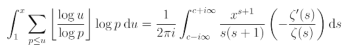

The predicted LaTex code is: \int _ { 0 } ^ { x } \sum _ { r \leq n } \left[ \frac { \operatorname { l o g } u } { \operatorname { l o g } p } \right] \operatorname { l o g } p \, \mathrm { d } \, a r } = \frac { 1 } { 2 \pi } \int _ { r = \operatorname { r + \infty } ^ { + \infty } \frac { x ^ { \nu + 1 } } { s ( s + 1 ) } \left( \begin{array} { c } { \zeta ^ { \prime } ( s ) } \\ { \zeta ( s ) } \right) \operatorname { l o s }

 The reconstrcuted image is:


<IPython.core.display.Latex object>

In [7]:
# Load the image from its path
img = Image.open('./test6.png')

# Convert the image to grayscale
img = img.convert('L')

# Convert the image to a 2D numpy array
img = 255 - np.array(img)

# Find the boundaries of the image
nonzero_rows, nonzero_cols = np.nonzero(img)
upper_row, lower_row = nonzero_rows.min(), nonzero_rows.max()
left_col, right_col = nonzero_cols.min(), nonzero_cols.max()

# Trim the image based on the boundaries
img = img[upper_row:lower_row+1, left_col:right_col+1]


print(f'The image size is: {img.shape}')


torch.cuda.empty_cache()
folder_name = 'ViT_experiment_90'
test_id = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config_data = read_file_in_dir('./experiment_data/'+folder_name, 'config.json')
exp_name = config_data['experiment_name']
generation_config = config_data['generation']
vocab = load_vocab(config_data['dataset']['vocab_dir'])

model = get_model(config_data, vocab).to(device)
state_dict = torch.load('./experiment_data/'+folder_name+'/best_model.pt', map_location=device)
model.load_state_dict(state_dict['model'])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Loaded model with {count_parameters(model)} parameters')

model.eval()

image = torch.tensor(img, dtype=torch.float32)
# Check if the size of the image is less than or equal to 128x1088
if img.shape[0] > 64 or img.shape[1] > 544:
    print("Error: The image size is too large. May affect accuracy!")
    n, m = image.shape
    ratio = max(n/63, m/543)
    n, m = int(n/ratio), int(m/ratio)
    image = transforms.Resize( (n, m) )(image.unsqueeze(0)).squeeze(0)

max_h, max_w = 64, 544


a, b = (max_w-m)//2, (max_h-n)//2
transform = transforms.Compose([
    transforms.Pad( (a, b, max_w-m-a, max_h-n-b), fill=0, padding_mode='constant')
])
image = transform(image) / 255


print('The original image is:')
plt.axis('off')
plt.imshow(255-image, cmap='gray')
plt.show()


with torch.no_grad():
    image = image.to(device).unsqueeze(0).unsqueeze(0)
    output = model.predict(image)
    output_cap = remove(get_caption(output[0], vocab, generation_config))
    output_cap = ' '.join(output_cap)
    
print(f'The predicted LaTex code is: {output_cap}')

print('\n The reconstrcuted image is:')
Latex('$' + output_cap + '$')